# Locally Linear Embedding
This is the fourth part in *Manifold Learning: Introduction and Foundational Algorithms*, and the entire project can be viewed at https://github.com/drewwilimitis/Manifold-Learning <br>
<br>
`Drew Wilimitis`

Locally linear embedding (LLE) is an intuitive approach based on the idea that small enough neighborhoods will represent patches lying along the manifold, which will then be approximately linear. By fitting locally along the manifold and learning the relationships defined by the intrinsic structure of the data, LLE can learn global, non-linear manifold geometries. <br>
<br>
The idea behind the LLE approach is that we define data points in terms of their local linear relationships. We define data point $x_i$ as a linear combination of its local neighbors, and then we find a lower dimensional embedding that preserves these local linear relationships.

![lle](https://user-images.githubusercontent.com/16658498/56095416-5c6ef800-5ea2-11e9-8ce0-5da013aee4e8.gif)<br>

**figure source**: S. T. Roweis and L. K. Saul. *Nonlinear dimensionality reduction by locally linear
embedding*

### Algorithm Outline (Locally Linear Embedding):
**Input:** Data vectors $\mathbf{x_1}, ..., \mathbf{x_n} \in \mathbb{R^d}$ with parameters k (nearest neighbors) and m (embedding dimension) <br>
**Output:** Lower dimensional embedding vectors $\mathbf{y_i}, ..., \mathbf{y_n} \in \mathbb{R^m}$ with $m < d$
<br>
**Steps**: <br>
1. Find $k$ nearest neighbors for each $x_i$ <br>
2. Solve for weights $W$ to reconstruct each $x_i$ as a linear combination of neighbors <br>
3. Solve for lower dimensional embedding coordinates $y_i \in \mathbb{R}^m$ that preserve local linear relationships

### Step 1: Find k nearest neighbors

First, the parameter k must be defined to specify the number of nearest neighbors we use to linearly model each $x_i$. There's no guaranteed way to know the optimal value of k before applying the algorithm, and different values of k can often drastically affect the performance of LLE. Before going further into the algorithm details, the following example using LLE from the `sklearn.manifold` library shows how locally linear embeddings can vary with the value of k.

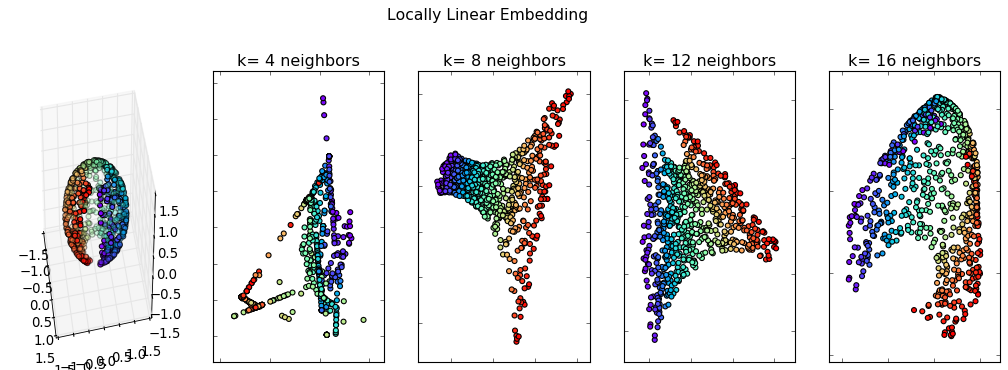

In [2]:
# modified from: https://scikit-learn.org/stable/auto_examples/manifold/plot_manifold_sphere.html
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

n_samples = 1000

# create our sphere
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# sever the poles from the sphere
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# plot our dataset
fig = plt.figure(figsize=(16, 10))
plt.suptitle("Locally Linear Embedding", fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# perform local linear wmbedding 
neighbors = np.arange(4, 20, 4)

for i, neighbor in enumerate(neighbors):
    trans_data = manifold.LocallyLinearEmbedding(neighbor, 2).fit_transform(sphere_data).T
    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow);
    ax.xaxis.set_major_formatter(NullFormatter());
    ax.yaxis.set_major_formatter(NullFormatter());
    plt.title('k= ' +str(neighbor) + ' neighbors')
    plt.axis('tight');
plt.show();

It seems that the optimal value of k is somewhere in the middle around 8-12. When using a low value for k, the linear combinations don't have enough neighboring points to accurately convey the structure of the manifold. For really high values of k, the neighborhoods start expanding to include too much of the global spherical structure and the resulting embedding becomes more curved.

## Step 2: Linear Combinations and Optimal Weights

After finding the nearest neighbors, we define the data points $x_i$ in terms of the local linear relationships within the neighborhood. For each $x_i$ in dimension $d$, we reconstruct $x_i$ using a linear combination of its k nearest neighbors. <br>
<br>
**Note**: this linear combination reconstruction is also in dimension $d$.  
<br>
For each point $x_i$ we define a linear combination with the weight coefficient matrix $W \in \mathbb{R}^{k \times n}$ that determines the contribution from each of the nearest neighbors $x_j$. For the weight matrix $W$, we have

$$\mathbf{W} = \begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1k} \\
w_{21} & w_{22} & \cdots & w_{2k} \\
\vdots & \vdots & \vdots & \vdots \\
w_{n1} & w_{n2} & \cdots & w_{nk}
\end{bmatrix}$$ <br>
and for some $x_i$ we have the linear combination <br>
<br>
$$\sum_{j=1}^{k} w_{ij} x_j = w_{i1} x_{1} + \cdots + w_{ik} x_{k}$$.<br>
Since we'd like to accurately reconstruct $x_i$ as a linear combination, we have the total reconstruction error defined by the following cost function: <br>
<br>
$$\mathcal{E}(W) = \sum_{i} ||x_i - \sum_{j} w_{ij} x_j||^2$$
<br>
This has a residual sum of squares form where we have the error as the Euclidean distance between the original $x_i$ and our nearest neighbors construction. The cost function is a function of the weights since the data $x_i$ is given, and so we minimize this cost function by finding the optimal weights with the lowest reconstruction error.

**Invariance to rotation, scaling, translation:**

By the way we defined the cost function, the optimal weights are invariant to rotation, scaling, and translation, so they reflect intrinsic geometric properties of the original data, as it's possible to imagine applying one of these Euclidean transformations and the local linear relationships remaining unchanged.

### Finding Weights with Constrained Least Squares

The optimal weights are the weights that minimize the cost function: <br>
<br>
$$\mathcal{E}(W) = \sum_{i} ||x_i - \sum_{j} w_{ij} x_j||^2$$
subject to the constraint: <br>
- The rows of the weight matrix sum to one: $\sum_{j} w_{ij} = 1$

Consider error for a particular $x_i$:  <br>
$$
\begin{equation}
\begin{aligned}
\\ \mathcal{E}_i & = ||x_i - \sum_{j} w_{ij} x_j||^2\\
            & = ||(w_{i1} + \cdots + w_{ik}) x_i - \sum_{j} w_{ij} x_j||^2 & \text{(sum of weights = 1)}\\
            & = ||\sum_{j} w_{ij}x_i - \sum_{j} w_{ij} x_j||^2\\
            & = ||\sum_{j} w_{ij} (x_i - x_j)||^2\\
\end{aligned}
\end{equation}$$

Now, let $z_j = x_i - x_j$, and let $\mathbf{z}$ be the k x d matrix where the rows are vectors in $\mathbb{R}^d$: <br>
<br>
$$\mathbf{z} = \begin{bmatrix}
z_{1} = x_{i} - x_{1} \\
z_{2} = x_{i} - x_{2} \\
\vdots & \\
z_{k} = x_{i} - x_{k} 
\end{bmatrix}$$

and $w_i$ is the k x 1 vector with weights for each neighbor of $x_i$. <br>
<br>
$$\mathbf{w_i} = \begin{bmatrix}
w_{i1} \\
w_{i2} \\
\vdots & \\
w_{ik}  
\end{bmatrix}$$

We can rewrite the cost function: <br>
$$
\begin{equation}
\begin{aligned}
\mathcal{E}_i & = ||\sum_{j} w_{ij} (x_i - x_j)||^2\\
            & = ||\sum_{j} w_{ij} z_j||^2\\
            & = ||w_{i1} z_1 + ... + w_{ik} z_k||^2\\
\\
            & = ||w_{i}^{T} z||^2\\
\\
            & = w_{i}^{T} z (w_{i}^{T} z)^{T}\\
\\
            & = w_{i}^{T} z z^{T} w_{i}\\
\end{aligned}
\end{equation}
$$

**Note**: the second to last line follows from $||\mathbf{r}||^2 = \mathbf{r} \mathbf{r}^T$ for a 1 x d row vector $\mathbf{r}$ and $w_{i}^{T} z$ is a 1 x d row vector.

$zz^{T}$ is the local covariance or **Gram matrix** centered at $x_i$, which we denote $G_i$. The Gram matrix is a symmetric, positive semi-definite k x k matrix containing inner products for the local neighborhood of $x_i$. <br>
<br>
$$G_{jk} = (x_i-x_j) \cdot (x_i - x_k)$$ 

$$\mathbf{G_i} = \begin{bmatrix}
(x_i-x_1) \cdot (x_i - x_1) & (x_i-x_1) \cdot (x_i - x_2) & \cdots & (x_i-x_1) \cdot (x_i - x_k) \\
(x_i-x_2) \cdot (x_i - x_1) & (x_i-x_2) \cdot (x_i - x_2) & \cdots & (x_i-x_2) \cdot (x_i - x_k) \\
\vdots & \vdots & \vdots & \vdots \\
(x_i-x_k) \cdot (x_i - x_1) & (x_i-x_k) \cdot (x_i - x_2) & \cdots & (x_i-x_k) \cdot (x_i - x_k)
\end{bmatrix}$$ <br>

We have the final form of the cost function: <br>
<br>
$$\mathcal{E}_i = w_{i}^{T} G_i w_{i}$$ <br>
**Lagrange Multiplier Problem**

We let $\mathbf{1}$ be the k x 1 matrix of all 1's so <br>
$$\mathbf{1}^T w_i = 1$$ <br>
represents our constraint that the weights sum to 1. <br>
<br>
We take partial derivatives and set to zero <br>
<br>
$$\mathcal{L}(w_i, \lambda) = w_{i}^{T} G_i w_{i} - \lambda(\mathbf{1}^T w_i - 1) = 0$$

\begin{equation}
\frac{\partial \mathcal{L}}{\partial w_i} = 2G_i w_i - \lambda \mathbf{1} = 0 \\
\\
\frac{\partial \mathcal{L}}{\partial \lambda} = \mathbf{1}^T w_i - \mathbf{1} = 0
\end{equation}

From the first partial derivative: <br>
$$2G_i w_i = \lambda \mathbf{1} $$

And if $G_i$ is invertible, we have a closed form to compute the optimal weights: <br>
<br>
$$\boxed {w_i = \frac{\lambda}{2} G_{i}^{-1} \mathbf{1}}$$ <br>
where $\lambda$ can be chosen to ensure everything sums to 1.

To avoid finding an explicit inverse, it's often much easier in practice to solve the linear system of equations given by <br>
<br>
$$\boxed{G_{i} \mathbf{w_{i}} = \mathbf{1}}$$ <br>
where each of the k equations is of the form <br>
<br>
$$\sum_{k} G_{j k} w_{ik}=1$$ <br>
and then finally we rescale the weights so that they sum to 1.

**Note:** We find the optimal weights for each point separately

### <font color='blue'> Example - Local Linear Combinations </font>

To find the optimal weights for given data, we use the following two functions from the `sklearn.manifold` implementation of LLE, which can be viewed here: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/locally_linear.py 

In [3]:
def barycenter_weights(X, Z, reg=1e-3):
    """Compute barycenter weights of X from Y along the first axis
    We estimate the weights to assign to each point in Y[i] to recover
    the point X[i]. The barycenter weights sum to 1.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_dim)
    Z : array-like, shape (n_samples, n_neighbors, n_dim)
    reg : float, optional
        amount of regularization to add for the problem to be
        well-posed in the case of n_neighbors > n_dim
    Returns
    -------
    B : array-like, shape (n_samples, n_neighbors)
    """
    n_samples, n_neighbors = X.shape[0], Z.shape[1]
    B = np.empty((n_samples, n_neighbors), dtype=X.dtype)
    v = np.ones(n_neighbors, dtype=X.dtype)

    # this might raise a LinalgError if G is singular and has trace
    # zero
    for i, A in enumerate(Z.transpose(0, 2, 1)):
        C = A.T - X[i]  # broadcasting
        G = np.dot(C, C.T)
        trace = np.trace(G)
        if trace > 0:
            R = reg * trace
        else:
            R = reg
        # add regularization term to diagonal of G
        G.flat[::Z.shape[1] + 1] += R
        # solve linear system of equations Gw=v
        w = solve(G, v, sym_pos=True)
        # rescale weights
        B[i, :] = w / np.sum(w)
    return B

In [4]:
from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix, find
from scipy.sparse.linalg import eigsh

def barycenter_kneighbors_graph(X, n_neighbors, reg=1e-3, n_jobs=None):
    """Computes the barycenter weighted graph of k-Neighbors for points in X
    Parameters
    ----------
    X : {array-like, NearestNeighbors}
        Sample data, shape = (n_samples, n_features), in the form of a
        numpy array or a NearestNeighbors object.
    n_neighbors : int
        Number of neighbors for each sample.
    reg : float, optional
        Amount of regularization when solving the least-squares
        problem. Only relevant if mode='barycenter'. If None, use the
        default.
    n_jobs : int or None, optional (default=None)
        The number of parallel jobs to run for neighbors search.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    Returns
    -------
    A : sparse matrix in CSR format, shape = [n_samples, n_samples]
        A[i, j] is assigned the weight of edge that connects i to j.
    See also
    --------
    sklearn.neighbors.kneighbors_graph
    sklearn.neighbors.radius_neighbors_graph
    """
    knn = NearestNeighbors(n_neighbors + 1, n_jobs=n_jobs).fit(X)
    X = knn._fit_X
    n_samples = X.shape[0]
    ind = knn.kneighbors(X, return_distance=False)[:, 1:]
    data = barycenter_weights(X, X[ind], reg=reg)
    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
    return csr_matrix((data.ravel(), ind.ravel(), indptr),
                      shape=(n_samples, n_samples))

In [5]:
from sklearn.metrics import pairwise_distances

# function that outputs N x k matrix with k nearest neighbors for each observation in X
def nearest_neighbors(X, k):
    # we use k+1 here since Xi will have the shortest distance to itself
    knn_matrix = np.zeros((len(X), k))
    # compute pairwise distances
    dist_matrix = pairwise_distances(X)
    # for each row find indices of k nearest neighbors
    for i in range(len(X)):
        knn_matrix[i] = dist_matrix[i,:].argsort()[1:k+1]
    return knn_matrix

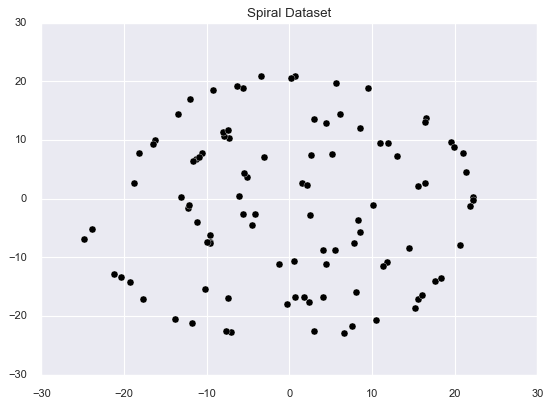

In [6]:
import seaborn as sns
sns.set()
plt.style.use('seaborn-notebook')

# spiral dataset
n = 100
u = np.sqrt(np.random.rand(n,1)) * 1440 * (2*np.pi)/360
x = -np.cos(u)*u + np.random.randn(n,1)*0.5
y = np.sin(u)*u + np.random.randn(n,1)*0.5
X = np.hstack((x,y))

plt.scatter(x, y, c = 'black',s=40)
plt.title('Spiral Dataset');

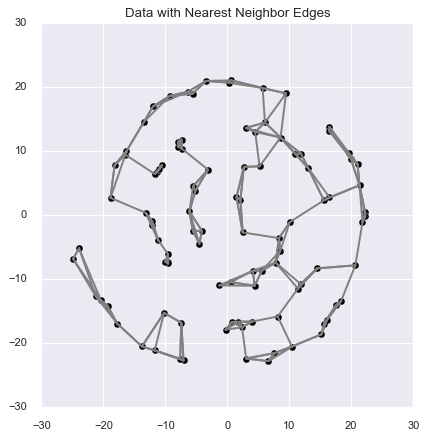

In [7]:
# loop through each data point and draw lines to nearest neighbors
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], alpha=1, c='black', s=40);
k = 3
neighbors = nearest_neighbors(X, k).astype('int')
for i in range(len(X)):
    knn = neighbors[i]
    for j in range(k):
        plt.plot(X[[i, knn[j]], 0], X[[i, knn[j]], 1], c='gray')

plt.title('Data with Nearest Neighbor Edges');

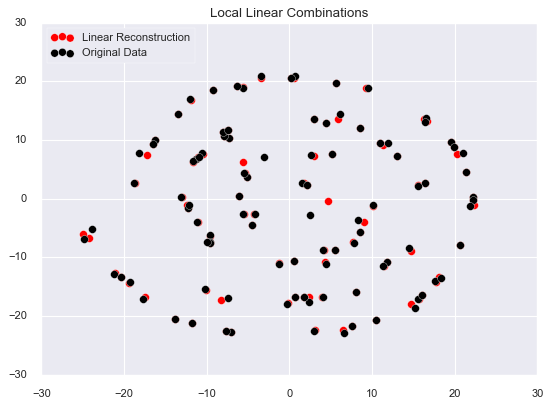

In [8]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
W = barycenter_kneighbors_graph(X, n_neighbors=k)

linear_combos = []
neighborhood_weights = []
for i in range(len(X)):
    weights = W.toarray()[i][neighbors[i]]
    neighborhood = X[neighbors[i]]
    weighted_neighbors = weights.reshape(-1,1)*neighborhood
    lin_x1 = np.sum(weighted_neighbors[:,0])
    lin_x2 = np.sum(weighted_neighbors[:,1])
    linear_combos.append([lin_x1, lin_x2])
    neighborhood_weights.append(weights)
linear_X = np.array(linear_combos)
plt.scatter(linear_X[:,0], linear_X[:,1], c='red', s=50, label='Linear Reconstruction')
plt.scatter(X[:,0], X[:,1], c='black', s=50, label='Original Data')
plt.title('Local Linear Combinations')
plt.legend(loc='upper left');

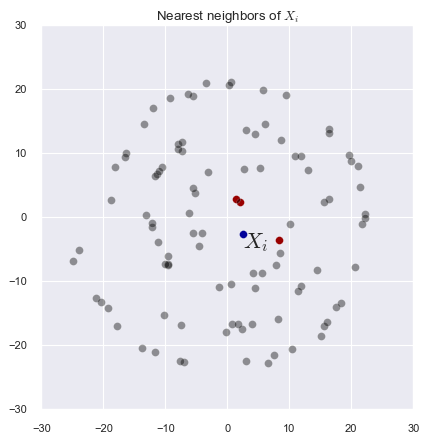

In [9]:
# neighbors for a given xi (maximum reconstruction error)
ix = np.argmax([np.linalg.norm(X[i] - linear_X[i]) for i in range(len(X))])
xi_neighbors = neighbors[ix] # indices of neighbors
plt.figure(figsize=(6,6))
plt.scatter(X[ix, 0], X[ix, 1], c='blue', s=50)
plt.text(X[ix, 0], X[ix, 1]-2, s='$X_i$', size=20)
plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='red', s=50)
plt.scatter(X[:,0], X[:,1], alpha=0.4, c='black', s=50)
plt.title('Nearest neighbors of $X_i$');

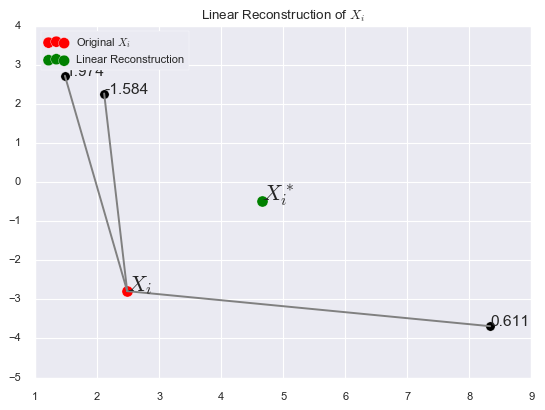

In [10]:
xi_weights = np.round(neighborhood_weights[ix],3)
plt.scatter(X[ix, 0], X[ix, 1], c='red', s=100, alpha=1, label='Original $X_i$')
plt.text(X[ix, 0], X[ix, 1], s='$X_i$', size=20)
plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='black', alpha=1, s=70)
plt.scatter(linear_X[ix,0], linear_X[ix,1], c='green', s=100, label='Linear Reconstruction')
plt.text(linear_X[ix,0], linear_X[ix,1], s='$X_i^*$', size=20)
for i in range(len(xi_neighbors)):
    plt.text(X[xi_neighbors[i], 0], X[xi_neighbors[i], 1], s=str(xi_weights[i]), size=14)
    plt.plot(X[[ix, xi_neighbors[i]], 0], X[[ix, xi_neighbors[i]], 1], c='gray')
plt.title('Linear Reconstruction of $X_i$')
plt.legend(loc='upper left');

In [11]:
# reconstruction errors
np.linalg.norm(X[ix] - linear_X[ix])
np.sum([np.linalg.norm(X[i] - linear_X[i]) for i in range(len(X))])

3.1818569563580184

23.322324346274435

## Step 3: Map to lower dimensional space

We now construct the mapping from each $x_i \in \mathbb{R^d}$ to its lower dimensional representation $y_i \in \mathbb{R^m}$. Since the optimal weights we found have certain invariant properties, we use these weights in this mapping. We define a new cost function with a similar form to the previous one, where we want to minimize reconstruction error:<br>
<br>
$$\phi(Y) = \sum_{i} ||y_i - \sum_{j} w_{ij} y_j||^2$$<br>
This time, the weights are fixed and we find optimal coordinates $y_i$ with the constraints: <br>
- $\sum_i y_i = 0$ (centered on the origin, translational degree of freedom)<br>
- $\frac{1}{N} \sum_i y_i y_i^T = \mathbf{I}$ (unit covariance, rotational degree of freedom) <br>

We rewrite the cost function making use of our constraints: <br>

$$
\begin{aligned} 
\Phi(\mathbf{Y}) &=\sum_{i=1}^{n}\left(y_{i}-\sum_{j} w_{i j} y_{j}\right)^{2} \\
&=\sum_{i=1}^{n} y_{i}^{2}-y_{i}\left(\sum_{j} w_{i j} y_{j}\right)-\left(\sum_{j} w_{i j} y_{j}\right) y_{i}+\left(\sum_{j} w_{i j} y_{j}\right)^{2} \\
&=\mathbf{Y}^{T} \mathbf{Y}-\mathbf{Y}^{T}(\mathbf{w} \mathbf{Y})-(\mathbf{w} \mathbf{Y})^{T} \mathbf{Y}+(\mathbf{w} \mathbf{Y})^{T}(\mathbf{w} \mathbf{Y}) \\
&=(\mathbf{Y}^T-\mathbf{Y}^T\mathbf{w}^T)(\mathbf{Y}-\mathbf{w}\mathbf{Y}) \\
&=\mathbf{Y}^T(\mathbf{I}-\mathbf{w}^T)(\mathbf{I}-\mathbf{w})\mathbf{Y} \\
&=\mathbf{Y}^{T}(\mathbf{I}-\mathbf{w})^{T}(\mathbf{I}-\mathbf{w}) \mathbf{Y} \end{aligned}
$$

Define the m x m matrix $M$:
$$
\begin{aligned} \mathbf{M} &= (\mathbf{I}-\mathbf{w})^{T}(\mathbf{I}-\mathbf{w}) \end{aligned}
$$

and so $$\Phi(\mathbf{Y})=\mathbf{Y}^{T} \mathbf{M} \mathbf{Y}$$

We set up a Lagrange multiplier $\mu$ to impose the constraint $n^{-1} \mathbf{Y}^{T} \mathbf{Y} = \mathbf{I}$ <br>
<br>
$$
\mathcal{L}(\mathbf{Y}, \mu)=\mathbf{Y}^{T} \mathbf{M} \mathbf{Y}-\mu\left(n^{-1} \mathbf{Y}^{T} \mathbf{Y}-1\right)
$$

$$
\begin{array}{c}{\frac{\partial \mathcal{L}}{\partial \mathbf{Y}}=2 \mathbf{M} \mathbf{Y}-2 \mu n^{-1} \mathbf{Y}=0} \\ {\mathbf{M Y}=\frac{\mu}{n} \mathbf{Y}}\end{array}
$$

By the last line, $Y$ is an eigenvector of $M$ and so to minimize 

$$\phi(Y) = Y^{T} M Y$$ <br>
we choose the bottom m+1 eigenvectors (with the smallest eigenvalues) of M as our embedding coordinates, discarding the smallest eigenvector-eigenvalue pair because the first eigenvector will be a unit vector with all equal components by our construction of $M$.

### <font color='blue'> Example - Toy datasets</font>

We first apply LLE to a synthetic dataset for manifold learning to see how the LLE algorithm can learn complex non-linear structures.

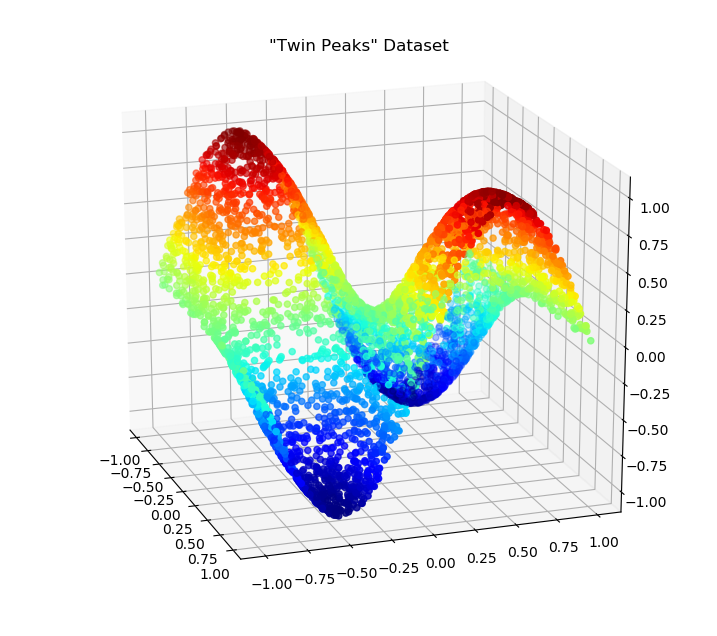

In [12]:
# twin peaks dataset
plt.style.use('default')
n = 5000
param = 1
xy = 1 - 2 * np.random.rand(2, n)
p = np.array([xy[1, :], xy[0, :], param * np.sin(np.pi * xy[0, :]) * np.tanh(3 * xy[1, :])]).T
color = p[:, 2]
fig = plt.figure(figsize = (9, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], c=color, cmap=plt.cm.jet)
plt.title('"Twin Peaks" Dataset', size=12)
ax.view_init(20, -19);

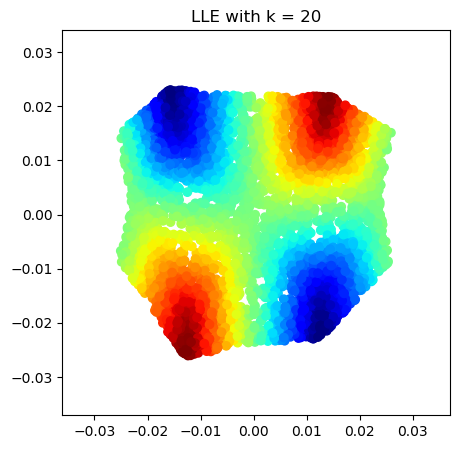

In [13]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=20) 
X_reduced = lle.fit_transform(p)
fig = plt.figure(figsize = (5, 5))
plt.title('LLE with k = 20', size=12)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, cmap=plt.cm.jet);

LLE performs fairly well on this highly non-linear dataset. In general the 2-dimensional embedding keeps close instances in $\mathbb{R^3}$ close together and further instances further apart. The areas of the original twin peaks dataset with the greatest curvature are not represented as well and this leads to the irregular, high density red and blue areas. <br>
<br>
Another synthetic dataset that can be challenging for manifold learning and LLE is the following construction of connected, clusters of data.

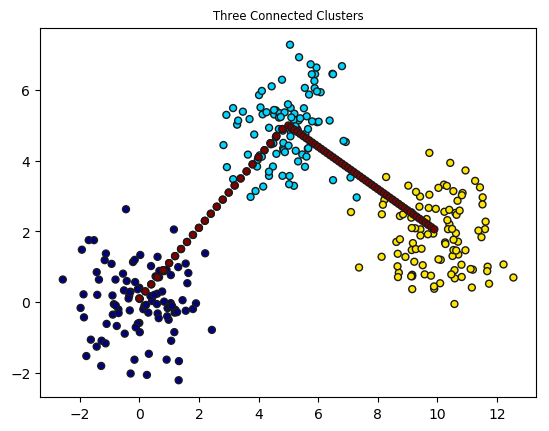

In [22]:
from sklearn.datasets import make_blobs
plt.title("Three Connected Clusters", fontsize='small')
X1, Y1 = make_blobs(n_samples=300,n_features=2, centers=[[0,0], [5,5], [10,2]])
t = np.arange(0,1,0.02)
l1 = np.array((t*5, t*5)).reshape(50,2)
l2 = np.hstack((np.array(5+5*t).reshape(-1,1),np.array(5+t*-3).reshape(-1,1)))
X = np.vstack((X1, l1, l2))
Y = np.vstack((Y1.reshape(-1,1), np.repeat(3,100).reshape(-1,1)))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y.reshape(400,),
            s=25, edgecolor='k', cmap=plt.cm.jet);

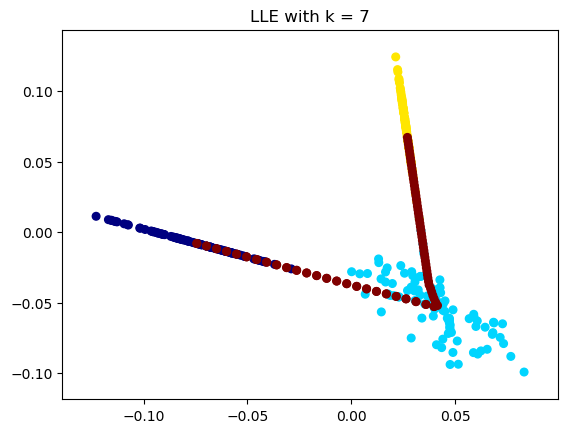

In [23]:
k = 7
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=k) 
X_reduced = lle.fit_transform(X)
plt.title('LLE with k = ' + str(k), size=12)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y.reshape(400,), s=30, cmap=plt.cm.jet);

LLE is unable to accurately learn the relationships in two of the clusters and performs poorly on this dataset.

### <font color='blue'> Example - Handwritten digits</font>

Next we apply LLE to a handwritten digits dataset where we only use digits 0-5.

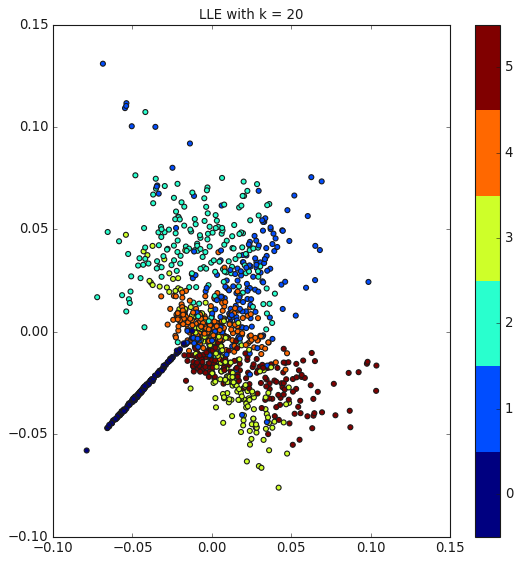

In [14]:
from sklearn import datasets
digits = datasets.load_digits(n_class=6)
data = digits.data
labels = digits.target
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=30) 
X_reduced = lle.fit_transform(data)
fig = plt.figure(figsize = (8, 8))
plt.title('LLE with k = 20', size=12)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap=plt.cm.get_cmap('jet', 6))
plt.colorbar(ticks=range(6))
plt.clim(-0.5, 5.5);

LLE performs moderately well on this task despite some seeming irregularities produced in the lower dimensional embedding.

### <font color='blue'> Example - Image Data</font>

In the final example, we apply LLE to one of the most common sources of high dimensional data - images. We load a sample image and display it using the `opencv-python`and the `matplotlib.image` libraries.

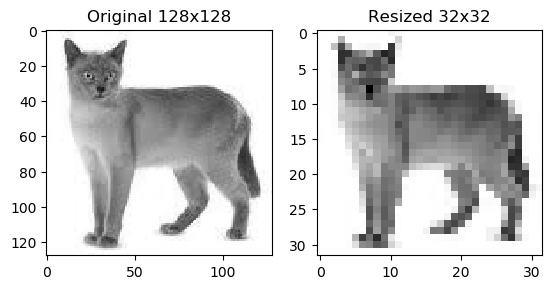

In [25]:
import cv2
import matplotlib.image as img
from skimage.color import rgb2gray
plt.style.use('default')

# read in the image
image = cv2.imread("images/cat3.jpg")
# convert to gray and resize
image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
res = cv2.resize(image, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
plt.subplot(121)
plt.title('Original 128x128')
plt.imshow(image,cmap='gray')
plt.subplot(122)
plt.title('Resized 32x32')
plt.imshow(res,cmap='gray')
plt.show();

After resizing our image, it is a 32 x 32 = 1024 dimensional array with numerical entries from 0 to 255 representing each pixel intensity. There is some obvious information loss during the compression.

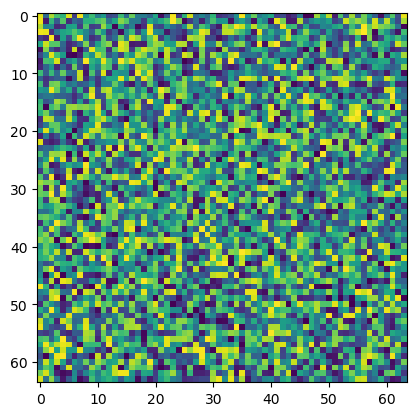

In [26]:
# create image with random noise
test_img = 255*np.random.rand(64, 64)
plt.imshow(test_img);

Next we create a set of images with our 32x32 cat image at various positions with the noise background.

In [27]:
# iterate and create shifted images
images = []
for i in range(33):
    for j in range(33):
        tmp = np.copy(test_img)
        # slide the cat image along the background
        tmp[i:i+32, j:j+32] = res
        images.append(tmp);

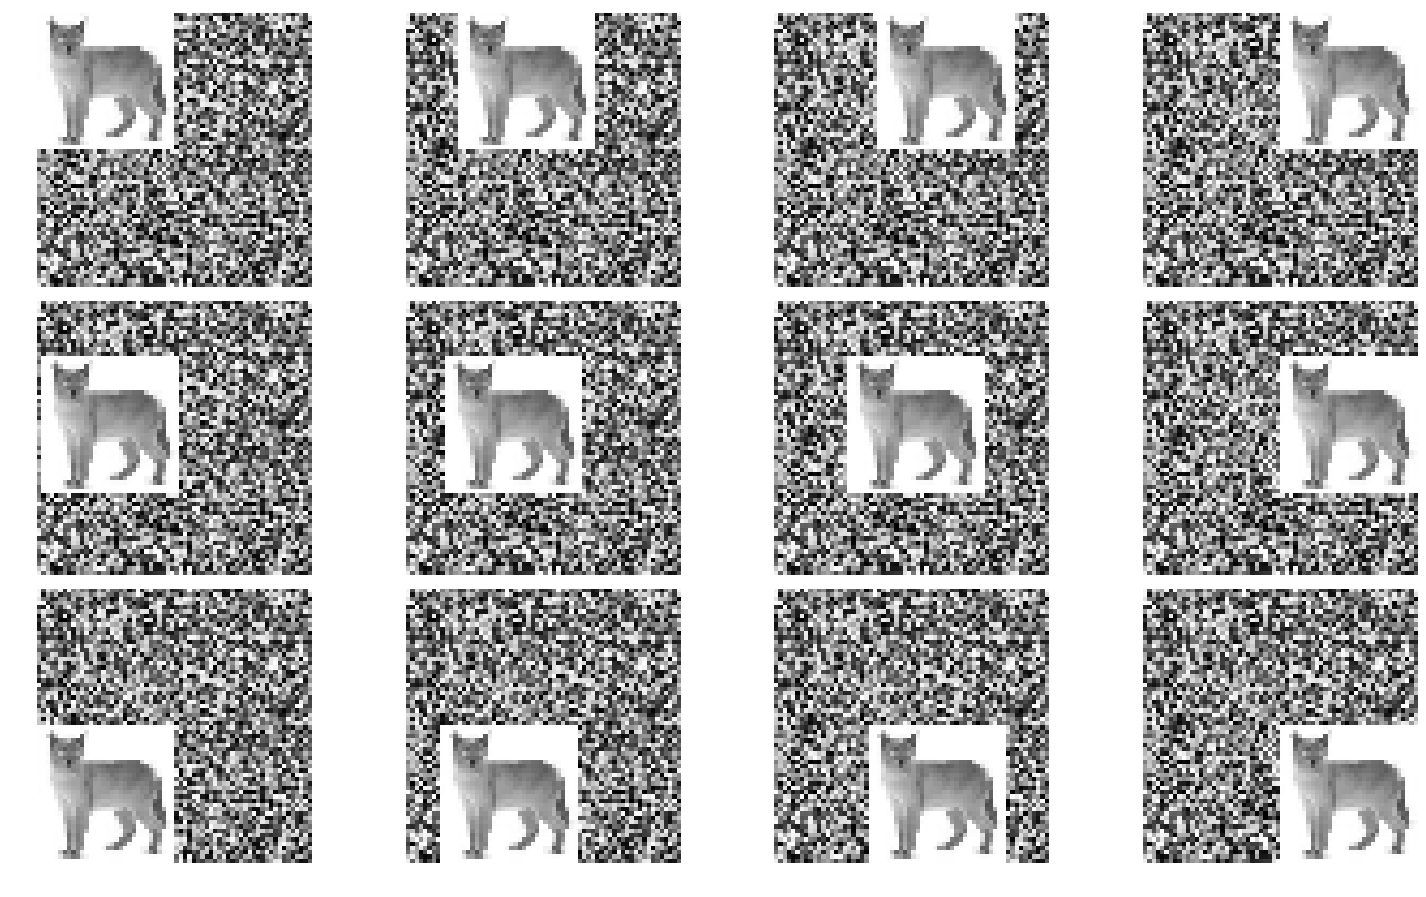

In [28]:
# plot some of the generated images
F = plt.figure(figsize=(15,10))
G = plt.GridSpec(3, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01, 
                 hspace=0.05, figure=F)
ax = plt.subplot(G[0])
_ = ax.imshow(images[0], cmap='gray')
selected_images = [0, 12, 24, 32, 430, 438, 446, 461, 1056, 1064, 1078, 1088]
ax.set_axis_off()
ax.set_aspect('equal')
for i in range(1, 12):
    ax = plt.subplot(G[i])
    _ = ax.imshow(images[selected_images[i]], cmap='gray')
    ax.set_axis_off()
    ax.set_aspect('equal');

In [29]:
# get dimensions, number samples
np.array(images).shape
64*64

(1089, 64, 64)

4096

We now have n=1089 samples with an extrinsic dimension of 64x64 = 4096. However, the intrinsic dimension is actually much lower since the only real dimensionality is the two dimensions or (x,y) coordinates of the shifted image. We apply LLE and visualize the results in two dimensions.  

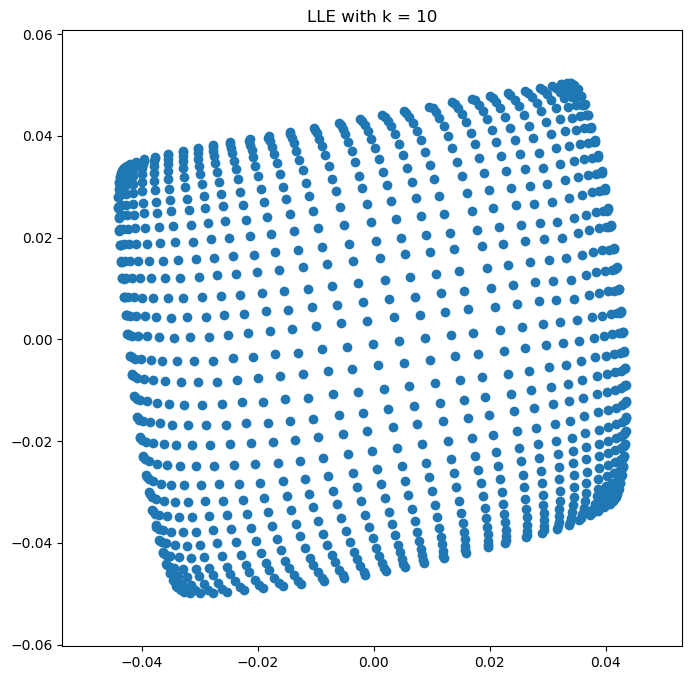

In [30]:
X = np.array(images).reshape(1089, 4096)
k = 10
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=k)
X_reduced = lle.fit_transform(X)
fig = plt.figure(figsize = (8, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.title('LLE with k = '+str(k), size=12);

In [31]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap, zoom=1),
                                      proj[i])
            ax.add_artist(imagebox)
        for i in selected_images:
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap='gray'), 
                proj[i])
            ax.add_artist(imagebox)

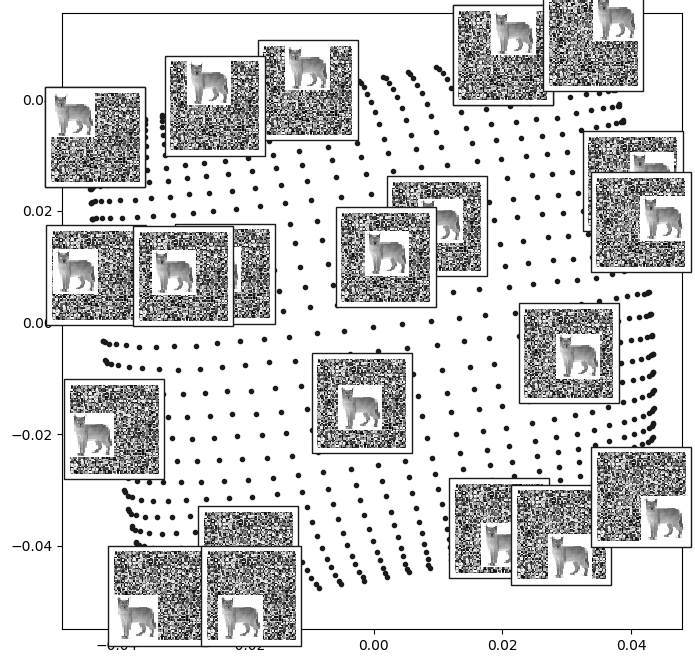

In [32]:
plt.figure(figsize=(8,8))
plot_components(X,
                model=LocallyLinearEmbedding(n_components=2, n_neighbors=k),
                thumb_frac=0.3,
                images=images);

LLE was able to uncover the intrinsic structure and preserve the higher dimensional relationships quite well as the images are plotted in the 2-d plane relative to where the cat is located in the image - such as in the corners and middle of this 2-d representation. 

In [1]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()

___

### References


-  [1] S. T. Roweis and L. K. Saul. *Nonlinear dimensionality reduction by locally linear
embedding*. Science 290, 2323-2326 (2000). <br>
-  [2] Think Globally, Fit Locally: Unsupervised Learning of Low Dimensional Manifolds
Lawrence K. Saul, Sam T. Roweis; 4(Jun):119-155, 2003. http://jmlr.csail.mit.edu/papers/v4/saul03a.html
-  [3] https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/locally_linear.py